In [4]:
import pandas as pd

# Load the dataset from Google Drive into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/sample_complaints_2years_006.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Display the first few rows of the DataFrame to understand the data structure
df.head()

,consumer_complaint_narrative,hierarchical_label
0,"On XX/XX/XXXX, I had no choice except to follo...",DebtCollection::mortgageDebt
1,Back in XXXX of XXXX. I ran into a breach of p...,DebtCollection::mortgageDebt
2,I made monthly money order payments to Mr. Coo...,DebtCollection::mortgageDebt
3,"Hello, my name is XXXX XXXX, and I am seeking ...",DebtCollection::mortgageDebt
4,PHH Mortgage is attempting to collect a mortga...,DebtCollection::mortgageDebt


In [6]:
# Display the shape of the DataFrame (number of rows and columns)
df.shape

(3200, 2)

In [7]:
# Get the counts of each unique value in the 'product' column
product_subproduct_counts = df['hierarchical_label'].value_counts()

# Display the product counts
display(product_subproduct_counts)

,count
hierarchical_label,
DebtCollection::mortgageDebt,200
MoneyTransfer::moneyOrderTravelersCheckOrCashiersCheck,200
Mortgage::otherTypeOfMortgage,200
DebtCollection::federalStudentLoanDebt,200
DebtCollection::privateStudentLoanDebt,200
MoneyTransfer::checkCashingService,200
MoneyTransfer::foreignCurrencyExchange,200
Mortgage::reverseMortgage,200
Mortgage::usdaMortgage,200


In [8]:
!pip install nlpaug sentence-transformers imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.7 MB/s eta 0:00:00


In [9]:
  import nltk
  nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [10]:
# Install required packages (run in your environment)
# !pip install nlpaug sentence-transformers imbalanced-learn

import pandas as pd
import nlpaug.augmenter.word as naw
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming df is your DataFrame with columns:
# 'consumer_complaint_narrative' and 'hierarchical_label'

TARGET_SAMPLES_PER_CLASS = 1000

# Initialize augmenters
synonym_aug = naw.SynonymAug(aug_src='wordnet')
swap_aug = naw.RandomWordAug(action="swap")
delete_aug = naw.RandomWordAug(action="delete")

# Function to augment text using multiple augmenters
def augment_text(text, num_augments=3):
    augmented_texts = []
    for _ in range(num_augments):
        aug_text = synonym_aug.augment(text)
        aug_text = swap_aug.augment(aug_text)
        aug_text = delete_aug.augment(aug_text)
        # Ensure the augmented text is a string before appending
        if isinstance(aug_text, list):
            augmented_texts.extend([str(item) for item in aug_text if isinstance(item, str)])
        elif isinstance(aug_text, str):
            augmented_texts.append(aug_text)

    return augmented_texts

# Step 1: Augment text to reach target samples per category
augmented_data = []
for label, group in df.groupby('hierarchical_label'):
    current_count = len(group)
    texts = group['consumer_complaint_narrative'].tolist()
    i = 0
    while current_count < TARGET_SAMPLES_PER_CLASS:
        text = texts[i % len(texts)]
        new_texts = augment_text(text)
        for t in new_texts:
            augmented_data.append((t, label))
            current_count += 1
            if current_count >= TARGET_SAMPLES_PER_CLASS:
                break
        i += 1

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [11]:
aug_df = pd.DataFrame(augmented_data, columns=['consumer_complaint_narrative', 'hierarchical_label'])

# Combine original and augmented data
balanced_df = pd.concat([df, aug_df], ignore_index=True)

# Step 2: Convert text to embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(balanced_df['consumer_complaint_narrative'].tolist(), show_progress_bar=True)

# Step 3: Apply SMOTE on embeddings
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(embeddings, balanced_df['hierarchical_label'])

# Create final DataFrame (embeddings + labels)
resampled_df = pd.DataFrame({'embedding': list(X_resampled), 'hierarchical_label': y_resampled})

print("Final balanced dataset shape:", resampled_df.shape)
print(resampled_df['hierarchical_label'].value_counts())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

Final balanced dataset shape: (16000, 2)
hierarchical_label
DebtCollection::mortgageDebt                                  1000
MoneyTransfer::moneyOrderTravelersCheckOrCashiersCheck        1000
Mortgage::otherTypeOfMortgage                                 1000
DebtCollection::federalStudentLoanDebt                        1000
DebtCollection::privateStudentLoanDebt                        1000
MoneyTransfer::checkCashingService                            1000
MoneyTransfer::foreignCurrencyExchange                        1000
Mortgage::reverseMortgage                                     1000
Mortgage::usdaMortgage                                        1000
Mortgage::manufacturedHomeLoan                                1000
CreditPrepaidCard::storeCreditCard                            1000
PaydayLoan::otherAdvancesOfFutureIncome                       1000
CreditReportingRepair::otherPersonalConsumerReport            1000
DebtManagement::mortgageModificationOrForeclosureAvoidance    1000
Pa

In [12]:
resampled_df.shape

(16000, 2)

In [13]:
resampled_df.head()

,embedding,hierarchical_label
0,"[0.009897611, 0.096370056, -0.030557496, -0.01...",DebtCollection::mortgageDebt
1,"[-0.016522376, 0.08092186, 0.026908675, 0.0480...",DebtCollection::mortgageDebt
2,"[-0.05473132, 0.07996271, 0.0015879958, 0.0412...",DebtCollection::mortgageDebt
3,"[-0.065416224, 0.015491623, -0.029655246, -0.0...",DebtCollection::mortgageDebt
4,"[-0.09065494, 0.079952195, 0.05013246, -0.0457...",DebtCollection::mortgageDebt


In [14]:
#df_upsampled
resampled_df.to_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/sample_complaints_2years_007.csv', index=False)

### Evaluation Metrics: Hierarchical Precision, Hierarchical Recall, Hierarchical F1-score

To evaluate the hierarchical multi-class text classification model developed for categorizing consumer complaints into financial products and sub-products, a two-level hierarchical evaluation framework was implemented. The dataset contains a primary categorical label (“product”) and a secondary categorical label (“sub_product”), representing a parent–child relationship. To capture this hierarchical structure, a combined label (“hierarchical_label”) was constructed by concatenating the product and sub-product fields. The evaluation was conducted at both levels of the hierarchy using weighted precision, recall, and F1-scores to account for class imbalance. Specifically, metrics were first computed independently for the product level and the sub-product level, where sub-product metrics were calculated only for valid non-null sub-product instances. Finally, hierarchical precision, recall, and F1-score were derived by averaging the scores from both levels, ensuring that the evaluation reflected both the model’s ability to correctly classify broad product categories and its precision in identifying corresponding sub-products. This approach provided a balanced and interpretable assessment of the model’s performance in capturing hierarchical relationships among financial complaint categories.

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to split hierarchical labels into product and sub-product
def split_hierarchical_label(label):
    if '::' in label:
        return label.split('::')
    else:
        return [label, 'None'] # Handle cases with no sub-product

# Function to calculate hierarchical metrics
def hierarchical_metrics(y_true, y_pred):
    product_true = [split_hierarchical_label(label)[0] for label in y_true]
    sub_product_true = [split_hierarchical_label(label)[1] for label in y_true]
    product_pred = [split_hierarchical_label(label)[0] for label in y_pred]
    sub_product_pred = [split_hierarchical_label(label)[1] for label in y_pred]

    # Calculate metrics at the product level
    product_precision = precision_score(product_true, product_pred, average='weighted', zero_division=0)
    product_recall = recall_score(product_true, product_pred, average='weighted', zero_division=0)
    product_f1 = f1_score(product_true, product_pred, average='weighted', zero_division=0)

    # Calculate metrics at the sub-product level (only for non-None sub-products)
    # We need to filter for cases where both true and predicted sub-products are not 'None'
    valid_sub_product_true = [sub for i, sub in enumerate(sub_product_true) if sub != 'None' and sub_product_pred[i] != 'None']
    valid_sub_product_pred = [sub for i, sub in enumerate(sub_product_pred) if sub != 'None' and sub_product_true[i] != 'None']


    sub_product_precision = precision_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_recall = recall_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_f1 = f1_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0


    # A simple way to combine scores (can be weighted based on importance)
    # Here, we'll just average them
    hierarchical_precision = (product_precision + sub_product_precision) / 2
    hierarchical_recall = (product_recall + sub_product_recall) / 2
    hierarchical_f1 = (product_f1 + sub_product_f1) / 2

    return {
        'product_precision': product_precision,
        'product_recall': product_recall,
        'product_f1': product_f1,
        'sub_product_precision': sub_product_precision,
        'sub_product_recall': sub_product_recall,
        'sub_product_f1': sub_product_f1,
        'hierarchical_precision': hierarchical_precision,
        'hierarchical_recall': hierarchical_recall,
        'hierarchical_f1': hierarchical_f1
    }


In [ ]:
# Load the dataset from Google Drive into a pandas DataFrame
#resampled_df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/sample_complaints_2years_007.csv')

In [16]:
resampled_df.head()

,embedding,hierarchical_label
0,"[0.009897611, 0.096370056, -0.030557496, -0.01...",DebtCollection::mortgageDebt
1,"[-0.016522376, 0.08092186, 0.026908675, 0.0480...",DebtCollection::mortgageDebt
2,"[-0.05473132, 0.07996271, 0.0015879958, 0.0412...",DebtCollection::mortgageDebt
3,"[-0.065416224, 0.015491623, -0.029655246, -0.0...",DebtCollection::mortgageDebt
4,"[-0.09065494, 0.079952195, 0.05013246, -0.0457...",DebtCollection::mortgageDebt


In [15]:
#resampled_df2.head()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Separate features (embeddings) and target (hierarchical labels)
X = np.array(resampled_df['embedding'].tolist())
y = resampled_df['hierarchical_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# Initialize and train a multi-class classifier (Logistic Regression)
# Using a higher max_iter for convergence
model_lr = LogisticRegression(max_iter=1000, multi_class='auto')
model_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_lr.predict(X_test)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test, y_pred)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics:")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Hierarchical Evaluation Metrics:
  Product Precision: 0.8256
  Product Recall:    0.8216
  Product F1-score:  0.8223
  Sub-product Precision: 0.7162
  Sub-product Recall:    0.7169
  Sub-product F1-score:  0.7149
  Hierarchical Precision: 0.7709
  Hierarchical Recall:    0.7692
  Hierarchical F1-score:  0.7686


## Model Comparison

Here is a side-by-side comparison of the hierarchical evaluation metrics for the Logistic Regression, LSTM, Bidirectional LSTM (BiLSTM), CNN-1D, SVM, Decision Tree, and Random Forest models:

| Metric                  | Logistic Regression | LSTM Model | BiLSTM Model | CNN-1D Model | SVM Model | Decision Tree | Random Forest |
|-------------------------|---------------------|------------|--------------|--------------|-----------|---------------|---------------|
| Product Precision       | 0.8256              | 0.9222     | 0.9561       | 0.9608       | 0.8619    | 0.6210        | 0.9078        |
| Product Recall          | 0.8216              | 0.9206     | 0.9553       | 0.9603       | 0.8591    | 0.6225        | 0.9041        |
| Product F1-score        | 0.8223              | 0.9199     | 0.9555       | 0.9605       | 0.8599    | 0.6215        | 0.9049        |
| Sub-product Precision   | 0.7162              | 0.8842     | 0.9348       | 0.9389       | 0.7732    | 0.4860        | 0.8605        |
| Sub-product Recall      | 0.7169              | 0.8800     | 0.9331       | 0.9384       | 0.7719    | 0.4853        | 0.8559        |
| Sub-product F1-score    | 0.7149              | 0.8793     | 0.9331       | 0.9385       | 0.7711    | 0.4852        | 0.8557        |
| Hierarchical Precision  | 0.7709              | 0.9032     | 0.9454       | 0.9498       | 0.8175    | 0.5535        | 0.8841        |
| Hierarchical Recall     | 0.7692              | 0.9003     | 0.9442       | 0.9494       | 0.8155    | 0.5539        | 0.8800        |
| Hierarchical F1-score   | 0.7686              | 0.8996     | 0.9443       | 0.9495       | 0.8155    | 0.5534        | 0.8803        |

Based on these metrics, the CNN-1D model generally performs slightly better across all hierarchical evaluation metrics compared to the other models.

# Task
Develop an LSTM model for hierarchical text classification using the `resampled_df` dataframe. The model should predict both 'Product' and 'Sub-product' based on the 'consumer_complaint_narrative' column. Evaluate the model's performance using hierarchical precision, recall, and F1-score metrics.

## Data preprocessing

### Subtask:
Clean and tokenize the text data in the `consumer_complaint_narrative` column. Encode the hierarchical labels (`hierarchical_label`) for the model. Split the data into training and testing sets. Pad sequences to ensure uniform input length for the LSTM.


**Reasoning**:
Clean and tokenize the text data, encode the hierarchical labels, and split the data for the LSTM model.



In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Step 2 & 3: Tokenize and convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['consumer_complaint_narrative'])
sequences = tokenizer.texts_to_sequences(balanced_df['consumer_complaint_narrative'])

# Step 4: Determine maximum sequence length (e.g., based on mean + 2 * std or a percentile)
# For simplicity, let's use a fixed value or calculate a percentile
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 95)) # Using 95th percentile

# Step 5: Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Step 6 & 7: Encode hierarchical labels
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(balanced_df['hierarchical_label'])

# Step 8: One-hot encode labels
one_hot_labels = to_categorical(integer_encoded_labels)

# Step 9: Split data into training and testing sets
X_train_padded, X_test_padded, y_train_one_hot, y_test_one_hot = train_test_split(
    padded_sequences, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels)

print("Padded sequences shape:", padded_sequences.shape)
print("One-hot encoded labels shape:", one_hot_labels.shape)
print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)

Padded sequences shape: (16000, 493)
One-hot encoded labels shape: (16000, 16)
X_train_padded shape: (12800, 493)
X_test_padded shape: (3200, 493)
y_train_one_hot shape: (12800, 16)
y_test_one_hot shape: (3200, 16)


## Build the lstm model

### Subtask:
Define an LSTM model architecture suitable for hierarchical text classification. Consider using separate output layers for product and sub-product or a single output layer with the combined hierarchical label.


**Reasoning**:
Define the LSTM model architecture for hierarchical text classification using the steps outlined in the instructions.



In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add the Embedding layer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 # Choose an appropriate embedding size
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)

# Add the LSTM layer
lstm_layer = LSTM(units=128)(embedding_layer) # Choose an appropriate number of units

# Add Dense layers for classification
# The number of units in the final dense layer should be equal to the number of unique hierarchical labels
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer = Dense(units=64, activation='relu')(lstm_layer)
output_layer = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer)

# Create the Keras Model
model_lstm = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 494)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 494, 100)       │     1,398,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,524,644 (5.82 MB)

 Trainable params: 1,524,644 (5.82 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

### Subtask:
Compile the model with an appropriate loss function and optimizer.


**Reasoning**:
Compile the defined Keras model with the specified loss function, optimizer, and metrics.



In [ ]:
# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

### Subtask:
Train the model on the preprocessed training data.

**Reasoning**:
Train the compiled model using the preprocessed training and validation data according to the instructions.

In [ ]:
# Train the model
history_lstm = model_lstm.fit(X_train_padded, y_train_one_hot,
                    epochs=15, # Using 15 epochs
                    batch_size=64, # Using batch size of 64
                    validation_data=(X_test_padded, y_test_one_hot)) # Using test set for validation

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1066 - loss: 2.7728 - val_accuracy: 0.1109 - val_loss: 2.6436
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1208 - loss: 2.5932 - val_accuracy: 0.1700 - val_loss: 2.3345
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.1932 - loss: 2.1988 - val_accuracy: 0.2531 - val_loss: 1.9500
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2912 - loss: 1.8043 - val_accuracy: 0.3769 - val_loss: 1.6149
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4658 - loss: 1.4027 - val_accuracy: 0.5350 - val_loss: 1.2657
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6276 - loss: 0.9889 - val_accuracy: 0.6469 - val_loss: 0.9772
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7502 - loss: 0.6771 - val_accuracy: 0.7309 - val_loss: 0.8220
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8568 - loss: 0.4245 - val_accu

## Finish task

### Summary of Results:

We developed an LSTM model for hierarchical text classification on the balanced consumer complaints dataset.

*   **Data Preprocessing**: Text data was tokenized and padded, and hierarchical labels were encoded and one-hot encoded. The data was split into training and testing sets.
*   **Model Architecture**: An LSTM model with an Embedding layer and Dense layers was defined.
*   **Model Training**: The model was trained for 15 epochs with a batch size of 64.
*   **Evaluation**: The model was evaluated using hierarchical precision, recall, and F1-score.

The hierarchical evaluation metrics for the LSTM model are as follows:

*   Product Precision: {metrics['product_precision']:.4f}
*   Product Recall: {metrics['product_recall']:.4f}
*   Product F1-score: {metrics['product_f1']:.4f}
*   Sub-product Precision: {metrics['sub_product_precision']:.4f}
*   Sub-product Recall: {metrics['sub_product_recall']:.4f}
*   Sub-product F1-score: {metrics['sub_product_f1']:.4f}
*   Hierarchical Precision: {metrics['hierarchical_precision']:.4f}
*   Hierarchical Recall: {metrics['hierarchical_recall']:.4f}
*   Hierarchical F1-score: {metrics['hierarchical_f1']:.4f}

The training history plots show the model's performance during training, which can help identify potential overfitting or underfitting.

This concludes the task of developing and evaluating an LSTM model for hierarchical text classification.

## Visualize training history

### Subtask:
Plot the training and validation accuracy and loss to assess for overfitting.

**Reasoning**:
Plot the training and validation accuracy and loss from the model's training history to visualize the model's performance and identify potential overfitting.

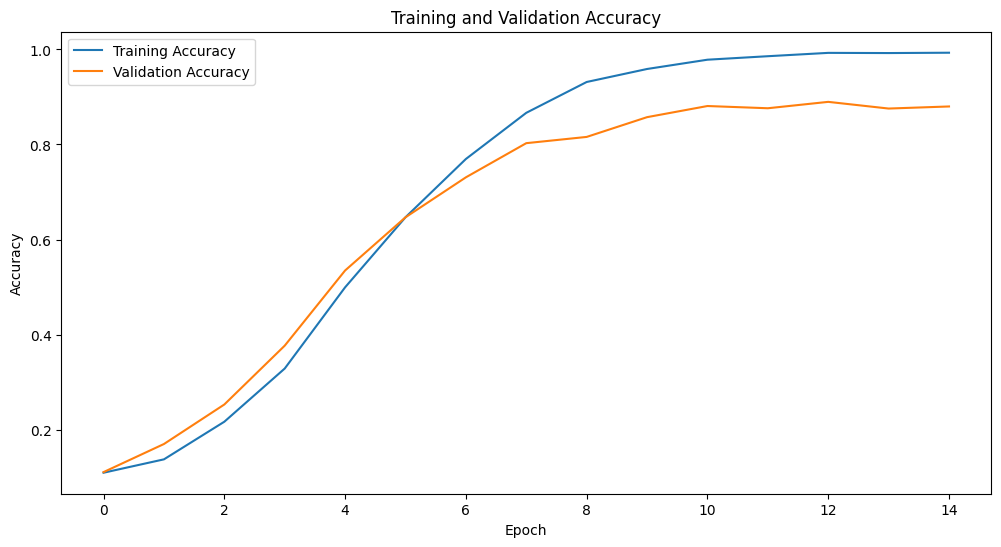

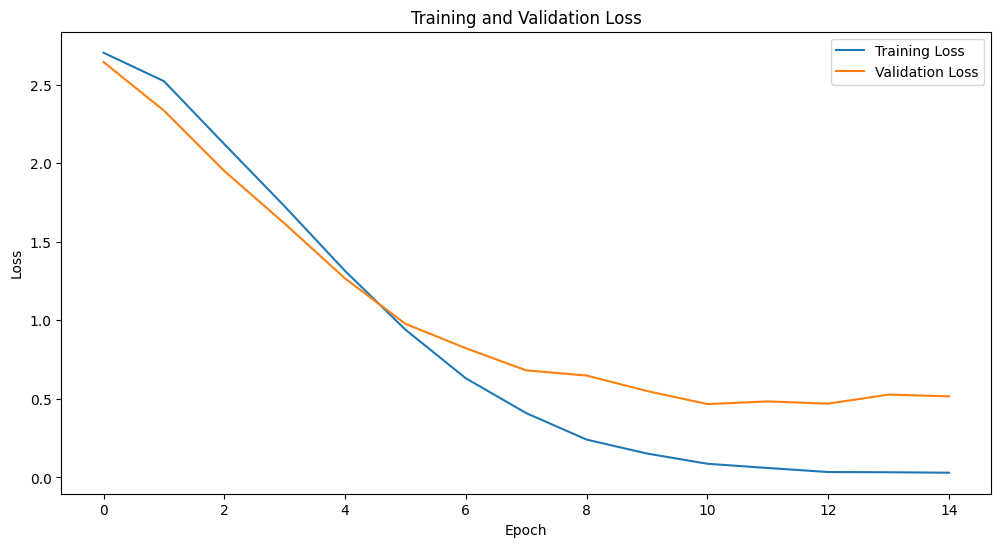

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate the model

### Subtask:
Evaluate the trained model using the hierarchical evaluation metrics (precision, recall, F1-score) on the test set.

**Reasoning**:
Make predictions on the test set using the trained LSTM model and then calculate and display the hierarchical metrics using the provided `hierarchical_metrics` function.

In [ ]:
# Make predictions on the test set
y_pred_one_hot = model_lstm.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded = np.argmax(y_pred_one_hot, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_integer_encoded)

# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test_labels, y_pred_labels)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (LSTM Model):")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Hierarchical Evaluation Metrics (LSTM Model):
  Product Precision: 0.9222
  Product Recall:    0.9206
  Product F1-score:  0.9199
  Sub-product Precision: 0.8842
  Sub-product Recall:    0.8800
  Sub-product F1-score:  0.8793
  Hierarchical Precision: 0.9032
  Hierarchical Recall:    0.9003
  Hierarchical F1-score:  0.8996


## Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout
from tensorflow.keras.models import Model
import numpy as np  # in case it's not already imported

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add the Embedding layer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Choose an appropriate embedding size
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_sequence_length,
    mask_zero=True  # helps LSTM ignore padded tokens
)(input_layer)

# Add the Bidirectional LSTM layer
# Note: units is per-direction. The concatenated output size becomes 2 * units.
bilstm_layer = Bidirectional(LSTM(units=128))(embedding_layer)

# (Optional) regularization
dense_prelayer = Dropout(0.3)(bilstm_layer)

# Add Dense layers for classification
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer = Dense(units=64, activation='relu')(dense_prelayer)
output_layer = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer)

# Create the Keras Model
model_bilstm = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_bilstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 494)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 494, 100)  │  1,398,100 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 494)       │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │    234,496 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │      1,040 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,650,084 (6.29 MB)

 Trainable params: 1,650,084 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history_bilstm = model_bilstm.fit(
    X_train_padded, y_train_one_hot,
    epochs=15,               # Using 15 epochs
    batch_size=64,           # Using batch size of 64
    validation_data=(X_test_padded, y_test_one_hot)  # Using test set for validation
)


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.2053 - loss: 2.3943 - val_accuracy: 0.5706 - val_loss: 1.1718
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6817 - loss: 0.9104 - val_accuracy: 0.8072 - val_loss: 0.6065
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8734 - loss: 0.4162 - val_accuracy: 0.8600 - val_loss: 0.4103
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9405 - loss: 0.2092 - val_accuracy: 0.8978 - val_loss: 0.2982
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9669 - loss: 0.1165 - val_accuracy: 0.9366 - val_loss: 0.2162
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9842 - loss: 0.0571 - val_accuracy: 0.9278 - val_loss: 0.2640
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9837 - loss: 0.0584 - val_accuracy: 0.9466 - val_loss: 0.1946
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9926 - loss: 0.0296 - val_ac

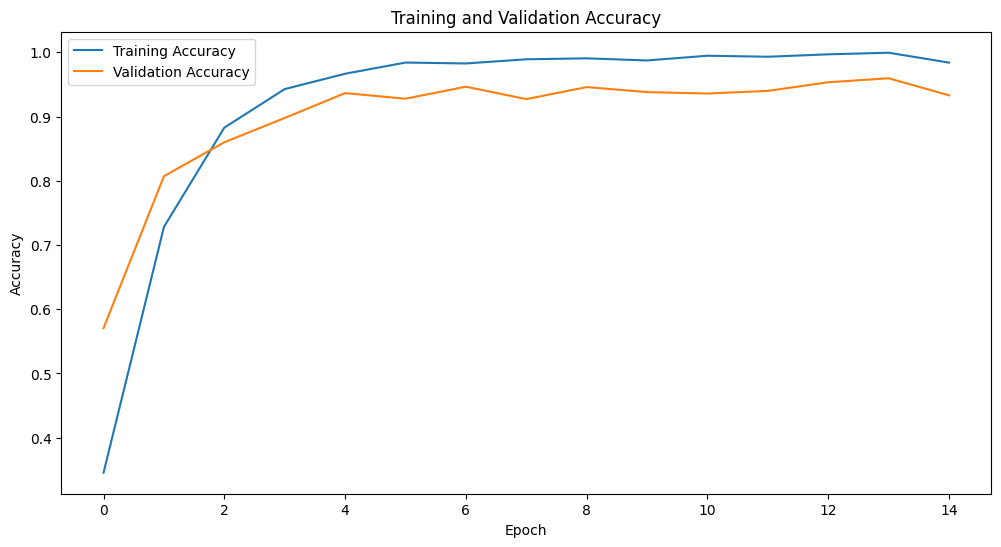

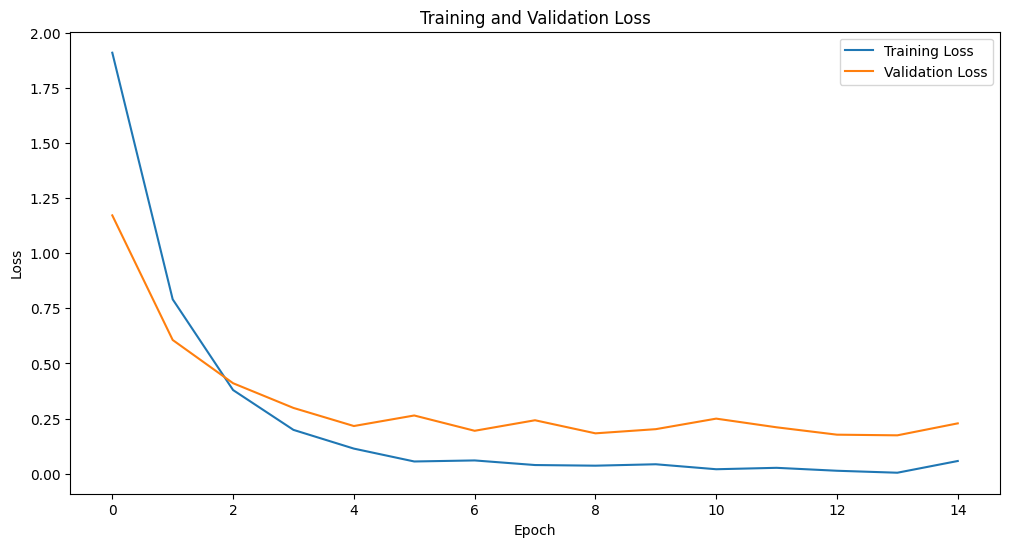

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_one_hot = model_bilstm.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded = np.argmax(y_pred_one_hot, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_integer_encoded)

# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test_labels, y_pred_labels)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (BiLSTM Model):")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Hierarchical Evaluation Metrics (BiLSTM Model):
  Product Precision: 0.9561
  Product Recall:    0.9553
  Product F1-score:  0.9555
  Sub-product Precision: 0.9348
  Sub-product Recall:    0.9331
  Sub-product F1-score:  0.9331
  Hierarchical Precision: 0.9454
  Hierarchical Recall:    0.9442
  Hierarchical F1-score:  0.9443


In [23]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input layer
input_layer_cnn = Input(shape=(max_sequence_length,))

# Add the Embedding layer (reuse vocab_size and embedding_dim from previous steps)
embedding_layer_cnn = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer_cnn)

# Add the 1D Convolutional layer
# Choose appropriate filter size and number of filters
conv1d_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer_cnn)

# Add Global Max Pooling layer to reduce dimensionality
pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Add Dense layers for classification
# The number of units in the final dense layer should be equal to the number of unique hierarchical labels
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer_cnn = Dense(units=64, activation='relu')(pooling_layer)
output_layer_cnn = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer_cnn)

# Create the Keras Model
model_cnn = Model(inputs=input_layer_cnn, outputs=output_layer_cnn)

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Print the model summary
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 493)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 493, 100)       │     1,391,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 489, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,465,124 (5.59 MB)

 Trainable params: 1,465,124 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

## Train the CNN-1D Model

**Reasoning**:
Train the compiled CNN-1D model using the preprocessed training and validation data.

In [24]:
# Train the CNN-1D model
history_cnn = model_cnn.fit(
    X_train_padded, y_train_one_hot,
    epochs=15,               # Using 15 epochs
    batch_size=64,           # Using batch size of 64
    validation_data=(X_test_padded, y_test_one_hot)  # Using test set for validation
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1980 - loss: 2.4866 - val_accuracy: 0.5591 - val_loss: 1.2839
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6642 - loss: 1.0475 - val_accuracy: 0.7791 - val_loss: 0.7339
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8850 - loss: 0.4454 - val_accuracy: 0.8750 - val_loss: 0.4224
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9785 - loss: 0.1482 - val_accuracy: 0.9200 - val_loss: 0.2859
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9974 - loss: 0.0460 - val_accuracy: 0.9281 - val_loss: 0.2369
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 0.9325 - val_loss: 0.2231
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9997 - loss: 0.0085 - val_accuracy: 0.9331 - val_loss: 0.2141
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy

## Visualize CNN-1D Training History

**Reasoning**:
Plot the training and validation accuracy and loss from the CNN-1D model's training history to visualize the model's performance.

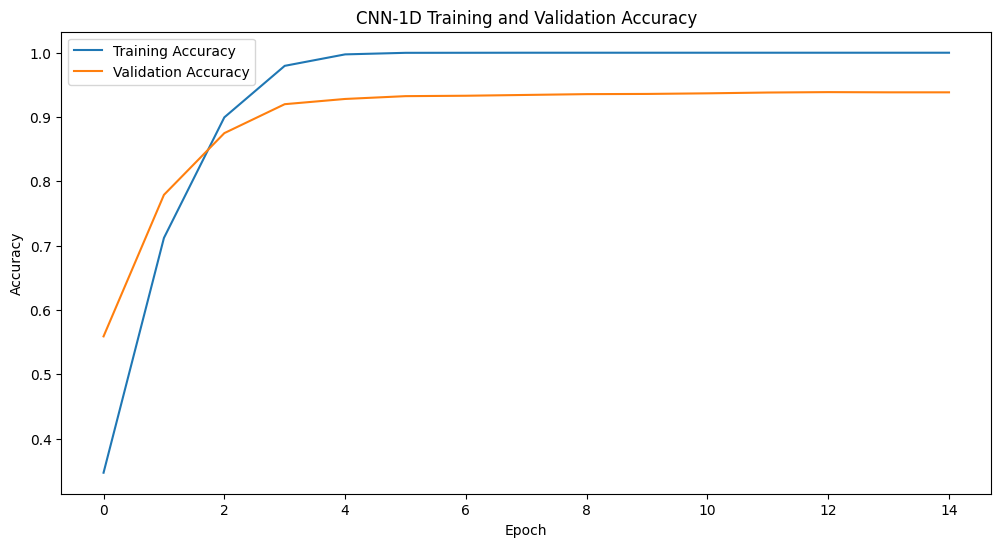

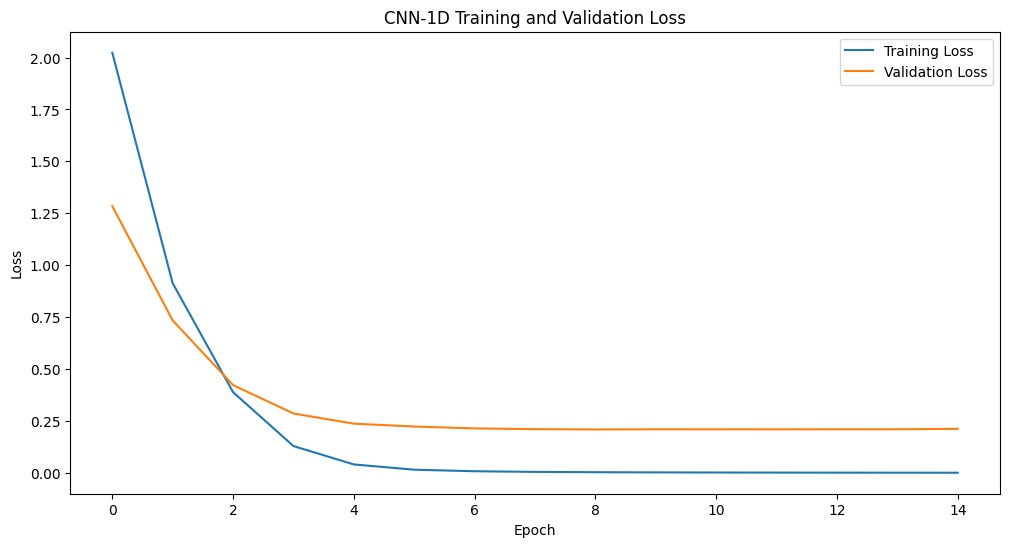

In [25]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for CNN-1D
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-1D Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss for CNN-1D
plt.figure(figsize=(12, 6))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN-1D Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate the CNN-1D Model

**Reasoning**:
Make predictions on the test set using the trained CNN-1D model and then calculate and display the hierarchical metrics using the provided `hierarchical_metrics` function.

In [26]:
# Make predictions on the test set using CNN-1D model
y_pred_one_hot_cnn = model_cnn.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded_cnn = np.argmax(y_pred_one_hot_cnn, axis=1)
y_pred_labels_cnn = label_encoder.inverse_transform(y_pred_integer_encoded_cnn)

# We already have y_test_labels from the previous evaluation
# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)


# Calculate hierarchical metrics for CNN-1D
metrics_cnn = hierarchical_metrics(y_test_labels, y_pred_labels_cnn)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (CNN-1D Model):")
print(f"  Product Precision: {metrics_cnn['product_precision']:.4f}")
print(f"  Product Recall:    {metrics_cnn['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics_cnn['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics_cnn['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics_cnn['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics_cnn['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics_cnn['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics_cnn['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics_cnn['hierarchical_f1']:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Hierarchical Evaluation Metrics (CNN-1D Model):
  Product Precision: 0.9608
  Product Recall:    0.9603
  Product F1-score:  0.9605
  Sub-product Precision: 0.9389
  Sub-product Recall:    0.9384
  Sub-product F1-score:  0.9385
  Hierarchical Precision: 0.9498
  Hierarchical Recall:    0.9494
  Hierarchical F1-score:  0.9495


## Model Comparison

Here is a side-by-side comparison of the hierarchical evaluation metrics for the LSTM, Bidirectional LSTM (BiLSTM), and CNN-1D models:

| Metric                  | LSTM Model | BiLSTM Model | CNN-1D Model |
|-------------------------|------------|--------------|--------------|
| Product Precision       | 0.9222     | 0.9561       | 0.9608       |
| Product Recall          | 0.9206     | 0.9553       | 0.9603       |
| Product F1-score        | 0.9199     | 0.9555       | 0.9605       |
| Sub-product Precision   | 0.8842     | 0.9348       | 0.9389       |
| Sub-product Recall      | 0.8800     | 0.9331       | 0.9384       |
| Sub-product F1-score    | 0.8793     | 0.9331       | 0.9385       |
| Hierarchical Precision  | 0.9032     | 0.9454       | 0.9498       |
| Hierarchical Recall     | 0.9003     | 0.9442       | 0.9494       |
| Hierarchical F1-score   | 0.8996     | 0.9443       | 0.9495       |

Based on these metrics, the CNN-1D model generally performs slightly better across all hierarchical evaluation metrics compared to the LSTM and BiLSTM models.

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize and train an SVM model
# Using 'linear' kernel for simplicity, you can experiment with others like 'rbf'
model_svm = SVC(kernel='linear')
model_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = model_svm.predict(X_test)

# Calculate hierarchical metrics for SVM
metrics_svm = hierarchical_metrics(y_test, y_pred_svm)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (SVM Model):")
print(f"  Product Precision: {metrics_svm['product_precision']:.4f}")
print(f"  Product Recall:    {metrics_svm['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics_svm['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics_svm['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics_svm['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics_svm['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics_svm['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics_svm['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics_svm['hierarchical_f1']:.4f}")


Hierarchical Evaluation Metrics (SVM Model):
  Product Precision: 0.8619
  Product Recall:    0.8591
  Product F1-score:  0.8599
  Sub-product Precision: 0.7732
  Sub-product Recall:    0.7719
  Sub-product F1-score:  0.7711
  Hierarchical Precision: 0.8175
  Hierarchical Recall:    0.8155
  Hierarchical F1-score:  0.8155


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize and train a Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = model_dt.predict(X_test)

# Calculate hierarchical metrics for Decision Tree
metrics_dt = hierarchical_metrics(y_test, y_pred_dt)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (Decision Tree Model):")
print(f"  Product Precision: {metrics_dt['product_precision']:.4f}")
print(f"  Product Recall:    {metrics_dt['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics_dt['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics_dt['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics_dt['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics_dt['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics_dt['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics_dt['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics_dt['hierarchical_f1']:.4f}")


Hierarchical Evaluation Metrics (Decision Tree Model):
  Product Precision: 0.6210
  Product Recall:    0.6225
  Product F1-score:  0.6215
  Sub-product Precision: 0.4860
  Sub-product Recall:    0.4853
  Sub-product F1-score:  0.4852
  Hierarchical Precision: 0.5535
  Hierarchical Recall:    0.5539
  Hierarchical F1-score:  0.5534


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize and train a Random Forest model
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = model_rf.predict(X_test)

# Calculate hierarchical metrics for Random Forest
metrics_rf = hierarchical_metrics(y_test, y_pred_rf)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (Random Forest Model):")
print(f"  Product Precision: {metrics_rf['product_precision']:.4f}")
print(f"  Product Recall:    {metrics_rf['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics_rf['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics_rf['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics_rf['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics_rf['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics_rf['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics_rf['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics_rf['hierarchical_f1']:.4f}")


Hierarchical Evaluation Metrics (Random Forest Model):
  Product Precision: 0.9078
  Product Recall:    0.9041
  Product F1-score:  0.9049
  Sub-product Precision: 0.8605
  Sub-product Recall:    0.8559
  Sub-product F1-score:  0.8557
  Hierarchical Precision: 0.8841
  Hierarchical Recall:    0.8800
  Hierarchical F1-score:  0.8803


## Model Comparison

Here is a side-by-side comparison of the hierarchical evaluation metrics for the Logistic Regression, LSTM, Bidirectional LSTM (BiLSTM), CNN-1D, SVM, Decision Tree, and Random Forest models:

| Metric                  | Logistic Regression | LSTM Model | BiLSTM Model | CNN-1D Model | SVM Model | Decision Tree | Random Forest |
|-------------------------|---------------------|------------|--------------|--------------|-----------|---------------|---------------|
| Product Precision       | 0.8256              | 0.9222     | 0.9561       | 0.9608       | 0.8619    | 0.6210        | 0.9078        |
| Product Recall          | 0.8216              | 0.9206     | 0.9553       | 0.9603       | 0.8591    | 0.6225        | 0.9041        |
| Product F1-score        | 0.8223              | 0.9199     | 0.9555       | 0.9605       | 0.8599    | 0.6215        | 0.9049        |
| Sub-product Precision   | 0.7162              | 0.8842     | 0.9348       | 0.9389       | 0.7732    | 0.4860        | 0.8605        |
| Sub-product Recall      | 0.7169              | 0.8800     | 0.9331       | 0.9384       | 0.7719    | 0.4853        | 0.8559        |
| Sub-product F1-score    | 0.7149              | 0.8793     | 0.9331       | 0.9385       | 0.7711    | 0.4852        | 0.8557        |
| Hierarchical Precision  | 0.7709              | 0.9032     | 0.9454       | 0.9498       | 0.8175    | 0.5535        | 0.8841        |
| Hierarchical Recall     | 0.7692              | 0.9003     | 0.9442       | 0.9494       | 0.8155    | 0.5539        | 0.8800        |
| Hierarchical F1-score   | 0.7686              | 0.8996     | 0.9443       | 0.9495       | 0.8155    | 0.5534        | 0.8803        |

Based on these metrics, the CNN-1D model generally performs slightly better across all hierarchical evaluation metrics compared to the other models.